# TensorFlow2 DenseNet-BiLSTM-CRF

## 1.导入数据
使用BROOK数据集 Person1

In [193]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow import keras
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
import matplotlib.colors as colors
import tensorflow_addons as tfa
import os.path 
from tensorflow_addons.layers import CRF

In [194]:
txt_file = 'hr/train22.txt'
# txt_file = 'dataset/speedtxt/train.txt'
f = open(txt_file)
imgspaths = []
hrs = []
for line in f.readlines():
    filename = line.split(',')[0]
    hr = line.split(',')[1]
    if hr[-1] == '\n':
        hr = hr[:-1]
        imgspaths.append(filename)
        hrs.append(int(hr))
    
y_train = np.array(hrs)



In [195]:
max_unit = np.max(hrs)

In [196]:
txt_file = 'hr/test22.txt'
# txt_file = 'dataset/speedtxt/test.txt'
f = open(txt_file)
imgspath2 = []
hrs = []
for line in f.readlines():
    filename = line.split(',')[0]
    hr = line.split(',')[1]
    if hr[-1] == '\n':
        hr = hr[:-1]
        imgspath2.append(filename)
        hrs.append(int(hr))
y_test = np.array(hrs)
        

In [197]:
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg']
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751562024.jpg']
# y_train = [[53],[54],[55]]
x_train = []
for imgspath in imgspaths:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
    img = colors.rgb_to_hsv(img)
    img = cv2.resize(img,(32,32))
    x_train.append(img)
x_train = np.array(x_train)

In [198]:
# imgspath2 = ['1565752827880.jpg']
# y_test = [[55]]
x_test = []
for imgspath in imgspath2:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
    img = colors.rgb_to_hsv(img)
    img = cv2.resize(img,(32,32))
    x_test.append(img)
x_test = np.array(x_test)

In [199]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [200]:
validation_set = (x_test, y_test)

## CNN和LSTM结果合并

In [201]:
from tensorflow.keras import layers
model = keras.Sequential()

In [202]:
x_shape = x_train.shape
cnet2 = DenseNet201(
    input_shape=(x_shape[1], x_shape[2], x_shape[3]),
    weights='imagenet',
    include_top=False
)
cnet2.trainable = True
img_input = layers.Input(shape=(x_shape[1], x_shape[2], x_shape[3]))
base_model = cnet2(img_input)

# pool = layers.GlobalAveragePooling2D()(final_layer)
flat = layers.Flatten()(base_model)
dense1 = layers.Dense(64)(flat)

In [203]:
reshape = layers.Reshape(target_shape=(x_shape[1]*x_shape[2], x_shape[3]))(img_input)
lstm_layer = layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True))(reshape)
decoded_sequence, potentials, sequence_length, chain_kernel = CRF(units=15)(lstm_layer)
dense2 = layers.Dense(64)(decoded_sequence)

In [204]:
merged_layer = layers.concatenate([dense1, dense2])
# merged_layer = dense1
outt = layers.Dense(max_unit + 1,activation='softmax')(merged_layer)
model = keras.Model(inputs=img_input, outputs=outt)
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
reshape_13 (Reshape)            (None, 1024, 3)      0           input_26[0][0]                   
__________________________________________________________________________________________________
densenet201 (Functional)        (None, 1, 1, 1920)   18321984    input_26[0][0]                   
__________________________________________________________________________________________________
bidirectional_13 (Bidirectional (None, 1024, 100)    21600       reshape_13[0][0]                 
______________________________________________________________________________________

In [205]:
%%time
history2 = model.fit(x_train, y_train, batch_size=64,epochs=200, validation_data = validation_set)

Epoch 1/200
147/147 [==============================] - 91s 622ms/step - loss: 6.9923 - accuracy: 0.0945 - val_loss: 10430.9082 - val_accuracy: 0.0257
Epoch 2/200
147/147 [==============================] - 138s 936ms/step - loss: 5.2797 - accuracy: 0.0933 - val_loss: 433.0221 - val_accuracy: 0.0714
Epoch 3/200
147/147 [==============================] - 133s 904ms/step - loss: 4.3936 - accuracy: 0.0968 - val_loss: 5801.5278 - val_accuracy: 0.0744
Epoch 4/200
147/147 [==============================] - 138s 940ms/step - loss: 4.3642 - accuracy: 0.1027 - val_loss: 3.7813 - val_accuracy: 0.0988
Epoch 5/200
147/147 [==============================] - 135s 920ms/step - loss: 3.7074 - accuracy: 0.1023 - val_loss: 5.0746 - val_accuracy: 0.0996
Epoch 6/200
147/147 [==============================] - 136s 924ms/step - loss: 3.7551 - accuracy: 0.1046 - val_loss: 8288.9092 - val_accuracy: 0.0274
Epoch 7/200
147/147 [==============================] - 142s 967ms/step - loss: 3.4592 - accuracy: 0.0990 - 

147/147 [==============================] - 138s 938ms/step - loss: 0.7379 - accuracy: 0.7345 - val_loss: 2.9478 - val_accuracy: 0.3301
Epoch 42/200
147/147 [==============================] - 136s 924ms/step - loss: 0.7948 - accuracy: 0.7188 - val_loss: 3.2580 - val_accuracy: 0.2822
Epoch 43/200
147/147 [==============================] - 139s 946ms/step - loss: 0.7099 - accuracy: 0.7477 - val_loss: 2.9870 - val_accuracy: 0.3078
Epoch 44/200
147/147 [==============================] - 136s 926ms/step - loss: 0.6659 - accuracy: 0.7631 - val_loss: 2.5126 - val_accuracy: 0.4220
Epoch 45/200
147/147 [==============================] - 136s 923ms/step - loss: 0.6353 - accuracy: 0.7793 - val_loss: 2.7382 - val_accuracy: 0.3771
Epoch 46/200
147/147 [==============================] - 139s 943ms/step - loss: 0.6026 - accuracy: 0.7825 - val_loss: 4.6004 - val_accuracy: 0.2326
Epoch 47/200
147/147 [==============================] - 136s 926ms/step - loss: 0.5525 - accuracy: 0.8053 - val_loss: 3.1241 

147/147 [==============================] - 140s 955ms/step - loss: 0.2040 - accuracy: 0.9366 - val_loss: 5.0232 - val_accuracy: 0.3578
Epoch 97/200
147/147 [==============================] - 143s 973ms/step - loss: 0.2032 - accuracy: 0.9365 - val_loss: 4.0388 - val_accuracy: 0.4224
Epoch 98/200
147/147 [==============================] - 144s 978ms/step - loss: 0.1653 - accuracy: 0.9475 - val_loss: 4.0425 - val_accuracy: 0.4164
Epoch 99/200
147/147 [==============================] - 143s 974ms/step - loss: 0.2247 - accuracy: 0.9338 - val_loss: 4.0002 - val_accuracy: 0.4395
Epoch 100/200
147/147 [==============================] - 142s 967ms/step - loss: 0.1829 - accuracy: 0.9446 - val_loss: 4.3841 - val_accuracy: 0.3835
Epoch 101/200
147/147 [==============================] - 142s 966ms/step - loss: 0.1726 - accuracy: 0.9469 - val_loss: 3.8233 - val_accuracy: 0.4434
Epoch 102/200
147/147 [==============================] - 147s 1s/step - loss: 0.1870 - accuracy: 0.9405 - val_loss: 3.7226 

147/147 [==============================] - 156s 1s/step - loss: 0.0997 - accuracy: 0.9709 - val_loss: 5.0150 - val_accuracy: 0.4344
Epoch 152/200
147/147 [==============================] - 159s 1s/step - loss: 0.1267 - accuracy: 0.9631 - val_loss: 4.6476 - val_accuracy: 0.4549
Epoch 153/200
147/147 [==============================] - 155s 1s/step - loss: 0.1766 - accuracy: 0.9498 - val_loss: 4.6816 - val_accuracy: 0.4630
Epoch 154/200
147/147 [==============================] - 155s 1s/step - loss: 0.1571 - accuracy: 0.9552 - val_loss: 5.1492 - val_accuracy: 0.4211
Epoch 155/200
147/147 [==============================] - 149s 1s/step - loss: 0.1667 - accuracy: 0.9528 - val_loss: 4.6245 - val_accuracy: 0.4716
Epoch 156/200
147/147 [==============================] - 147s 1000ms/step - loss: 0.1432 - accuracy: 0.9602 - val_loss: 4.6030 - val_accuracy: 0.4489
Epoch 157/200
147/147 [==============================] - 154s 1s/step - loss: 0.1463 - accuracy: 0.9582 - val_loss: 4.5178 - val_accur

In [206]:
model.evaluate(x=x_test, y=y_test,verbose=1)

74/74 [==============================] - 22s 302ms/step - loss: 5.2660 - accuracy: 0.4498


[5.266026496887207, 0.44976484775543213]

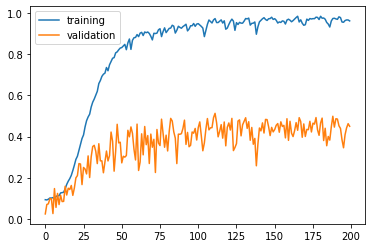

In [207]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()